# Week 8, Day 5: Ensemble Methods

## Learning Objectives
- Understand ensemble diversity and its importance
- Implement voting classifiers
- Build stacking models for trading
- Combine model predictions optimally

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
data_path = '../datasets/raw_data/combined_adjusted_close.csv'
prices = pd.read_csv(data_path, index_col='Date', parse_dates=True)

def create_features(price_series):
    df = pd.DataFrame(index=price_series.index)
    
    for period in [1, 5, 10, 20]:
        df[f'ret_{period}d'] = price_series.pct_change(period).shift(1)
    
    sma_5 = price_series.rolling(5).mean()
    sma_20 = price_series.rolling(20).mean()
    df['sma_cross'] = ((sma_5 / sma_20) - 1).shift(1)
    df['price_vs_sma20'] = ((price_series / sma_20) - 1).shift(1)
    
    delta = price_series.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = (100 - 100 / (1 + gain / loss)).shift(1)
    
    df['volatility'] = price_series.pct_change().rolling(20).std().shift(1)
    
    df['target'] = (price_series.pct_change().shift(-1) > 0).astype(int)
    
    return df.dropna()

spy_data = create_features(prices['SPY'])
feature_cols = [c for c in spy_data.columns if c != 'target']

X = spy_data[feature_cols]
y = spy_data['target']

# Time-based split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training: {len(X_train)}, Test: {len(X_test)}")

Training: 590, Test: 148


## 1. Why Ensembles Work: Model Diversity

In [2]:
# Train individual models
models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=10),
}

# Scale features for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predictions = {}
results = []

for name, model in models.items():
    if name in ['Logistic', 'KNN']:
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]
    
    predictions[name] = pred
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    
    results.append({'Model': name, 'Accuracy': acc, 'AUC': auc})

print("Individual Model Performance")
print("="*50)
print(pd.DataFrame(results).to_string(index=False))

Individual Model Performance
            Model  Accuracy      AUC
         Logistic  0.527027 0.576844
    Decision Tree  0.554054 0.555929
    Random Forest  0.540541 0.478058
Gradient Boosting  0.560811 0.517740
              KNN  0.459459 0.463212


In [3]:
# Check model agreement (diversity)
pred_df = pd.DataFrame(predictions)

# Correlation of predictions
corr_matrix = pred_df.corr()

print("Model Prediction Correlation (Lower = More Diverse)")
print("="*60)
print(corr_matrix.round(3).to_string())

# Agreement rate
agreement = (pred_df.nunique(axis=1) == 1).mean()
print(f"\nAll models agree: {agreement:.2%}")
print(f"Models disagree: {1-agreement:.2%}")

Model Prediction Correlation (Lower = More Diverse)
                   Logistic  Decision Tree  Random Forest  Gradient Boosting    KNN
Logistic              1.000          0.133          0.477              0.243  0.193
Decision Tree         0.133          1.000          0.093              0.241  0.277
Random Forest         0.477          0.093          1.000              0.283  0.335
Gradient Boosting     0.243          0.241          0.283              1.000  0.150
KNN                   0.193          0.277          0.335              0.150  1.000

All models agree: 30.41%
Models disagree: 69.59%


## 2. Voting Classifier

In [4]:
# Hard voting (majority vote)
hard_voting = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ],
    voting='hard'
)

# Soft voting (average probabilities)
soft_voting = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ],
    voting='soft'
)

# Train and evaluate
hard_voting.fit(X_train, y_train)
soft_voting.fit(X_train, y_train)

hard_acc = hard_voting.score(X_test, y_test)
soft_acc = soft_voting.score(X_test, y_test)
soft_proba = soft_voting.predict_proba(X_test)[:, 1]
soft_auc = roc_auc_score(y_test, soft_proba)

print("Voting Classifier Results")
print("="*50)
print(f"Hard Voting Accuracy: {hard_acc:.4f}")
print(f"Soft Voting Accuracy: {soft_acc:.4f}")
print(f"Soft Voting AUC: {soft_auc:.4f}")

Voting Classifier Results
Hard Voting Accuracy: 0.5676
Soft Voting Accuracy: 0.5676
Soft Voting AUC: 0.5445


In [5]:
# Weighted voting (give more weight to better models)
weighted_voting = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ],
    voting='soft',
    weights=[2, 3, 1]  # GB gets highest weight
)

weighted_voting.fit(X_train, y_train)
weighted_acc = weighted_voting.score(X_test, y_test)
weighted_proba = weighted_voting.predict_proba(X_test)[:, 1]
weighted_auc = roc_auc_score(y_test, weighted_proba)

print(f"\nWeighted Voting Accuracy: {weighted_acc:.4f}")
print(f"Weighted Voting AUC: {weighted_auc:.4f}")


Weighted Voting Accuracy: 0.5743
Weighted Voting AUC: 0.5318


## 3. Stacking

In [6]:
# Stacking: use a meta-learner to combine base models
stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,  # Cross-validation for generating meta-features
    passthrough=False  # Don't include original features
)

stacking.fit(X_train, y_train)
stack_acc = stacking.score(X_test, y_test)
stack_proba = stacking.predict_proba(X_test)[:, 1]
stack_auc = roc_auc_score(y_test, stack_proba)

print("Stacking Classifier Results")
print("="*50)
print(f"Stacking Accuracy: {stack_acc:.4f}")
print(f"Stacking AUC: {stack_auc:.4f}")

Stacking Classifier Results
Stacking Accuracy: 0.5608
Stacking AUC: 0.4751


In [7]:
# Stacking with passthrough (original features + base model predictions)
stacking_passthrough = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
    ],
    final_estimator=GradientBoostingClassifier(n_estimators=50, max_depth=2, random_state=42),
    cv=5,
    passthrough=True
)

stacking_passthrough.fit(X_train, y_train)
stack_pt_acc = stacking_passthrough.score(X_test, y_test)
stack_pt_proba = stacking_passthrough.predict_proba(X_test)[:, 1]
stack_pt_auc = roc_auc_score(y_test, stack_pt_proba)

print(f"\nStacking with Passthrough Accuracy: {stack_pt_acc:.4f}")
print(f"Stacking with Passthrough AUC: {stack_pt_auc:.4f}")


Stacking with Passthrough Accuracy: 0.5135
Stacking with Passthrough AUC: 0.4338


## 4. Custom Ensemble for Trading

In [8]:
class TradingEnsemble:
    """
    Custom ensemble that combines models and outputs trading signals.
    """
    
    def __init__(self, base_models, weights=None, threshold=0.5, min_agreement=0.6):
        self.base_models = base_models
        self.weights = weights or [1.0] * len(base_models)
        self.threshold = threshold
        self.min_agreement = min_agreement
    
    def fit(self, X, y):
        for name, model in self.base_models:
            model.fit(X, y)
        return self
    
    def predict_proba(self, X):
        """Weighted average of probabilities."""
        probas = []
        for (name, model), weight in zip(self.base_models, self.weights):
            proba = model.predict_proba(X)[:, 1]
            probas.append(proba * weight)
        
        return np.sum(probas, axis=0) / sum(self.weights)
    
    def get_agreement(self, X):
        """Calculate model agreement (0 to 1)."""
        predictions = []
        for name, model in self.base_models:
            pred = model.predict(X)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        agreement = np.abs(predictions.mean(axis=0) - 0.5) * 2
        return agreement
    
    def get_trading_signals(self, X, confidence_threshold=0.55):
        """
        Generate trading signals based on ensemble consensus.
        Returns: 1 (long), -1 (short), 0 (no trade)
        """
        proba = self.predict_proba(X)
        agreement = self.get_agreement(X)
        
        signals = np.zeros(len(X))
        
        # Long: high probability + high agreement
        long_mask = (proba > confidence_threshold) & (agreement > self.min_agreement)
        signals[long_mask] = 1
        
        # Short: low probability + high agreement
        short_mask = (proba < (1 - confidence_threshold)) & (agreement > self.min_agreement)
        signals[short_mask] = -1
        
        return signals, proba, agreement

# Create and train ensemble
trading_ensemble = TradingEnsemble(
    base_models=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('ada', AdaBoostClassifier(n_estimators=50, random_state=42)),
    ],
    weights=[1.0, 2.0, 1.0],  # Higher weight for GB
    min_agreement=0.6
)

trading_ensemble.fit(X_train, y_train)

# Get signals
signals, probas, agreement = trading_ensemble.get_trading_signals(X_test, confidence_threshold=0.55)

print("Trading Ensemble Signals")
print("="*50)
print(f"Long signals: {(signals == 1).sum()}")
print(f"Short signals: {(signals == -1).sum()}")
print(f"No trade: {(signals == 0).sum()}")
print(f"Mean agreement: {agreement.mean():.3f}")

Trading Ensemble Signals
Long signals: 64
Short signals: 13
No trade: 71
Mean agreement: 0.734


## 5. Ensemble Comparison

In [9]:
# Compare all methods
comparison = []

# Individual best model
best_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
best_model.fit(X_train, y_train)
comparison.append({
    'Method': 'Single GB',
    'Accuracy': best_model.score(X_test, y_test),
    'AUC': roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
})

# Soft voting
comparison.append({
    'Method': 'Soft Voting',
    'Accuracy': soft_acc,
    'AUC': soft_auc
})

# Weighted voting
comparison.append({
    'Method': 'Weighted Voting',
    'Accuracy': weighted_acc,
    'AUC': weighted_auc
})

# Stacking
comparison.append({
    'Method': 'Stacking',
    'Accuracy': stack_acc,
    'AUC': stack_auc
})

# Stacking with passthrough
comparison.append({
    'Method': 'Stacking + Passthrough',
    'Accuracy': stack_pt_acc,
    'AUC': stack_pt_auc
})

# Custom trading ensemble
ensemble_proba = trading_ensemble.predict_proba(X_test)
ensemble_pred = (ensemble_proba > 0.5).astype(int)
comparison.append({
    'Method': 'Custom Trading Ensemble',
    'Accuracy': accuracy_score(y_test, ensemble_pred),
    'AUC': roc_auc_score(y_test, ensemble_proba)
})

comparison_df = pd.DataFrame(comparison)
print("Ensemble Method Comparison")
print("="*60)
print(comparison_df.to_string(index=False))

Ensemble Method Comparison
                 Method  Accuracy      AUC
              Single GB  0.560811 0.517740
            Soft Voting  0.567568 0.544538
        Weighted Voting  0.574324 0.531839
               Stacking  0.560811 0.475070
 Stacking + Passthrough  0.513514 0.433800
Custom Trading Ensemble  0.554054 0.530159


## 6. Trading Backtest with Ensemble

In [10]:
# Calculate actual returns
actual_returns = prices['SPY'].pct_change().shift(-1).loc[X_test.index]

# Strategy returns
strategy_returns = signals * actual_returns.values

# Performance metrics
cum_strategy = (1 + strategy_returns).cumprod()
cum_buyhold = (1 + actual_returns).cumprod()

total_return = cum_strategy[-1] - 1
bh_return = cum_buyhold.iloc[-1] - 1
sharpe = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() > 0 else 0
bh_sharpe = np.sqrt(252) * actual_returns.mean() / actual_returns.std()

# Win rate (when trading)
trading_mask = signals != 0
win_rate = (strategy_returns[trading_mask] > 0).sum() / trading_mask.sum() if trading_mask.sum() > 0 else 0

print("Ensemble Trading Backtest")
print("="*50)
print(f"\n{'Metric':<20} | {'Ensemble':>12} | {'Buy & Hold':>12}")
print("-"*50)
print(f"{'Total Return':<20} | {total_return:>11.2%} | {bh_return:>11.2%}")
print(f"{'Sharpe Ratio':<20} | {sharpe:>12.2f} | {bh_sharpe:>12.2f}")
print(f"{'Win Rate':<20} | {win_rate:>11.2%} | {'N/A':>12}")
print(f"{'# Trades':<20} | {int(trading_mask.sum()):>12} | {'N/A':>12}")

Ensemble Trading Backtest

Metric               |     Ensemble |   Buy & Hold
--------------------------------------------------
Total Return         |        nan% |        nan%
Sharpe Ratio         |         0.00 |         1.26
Win Rate             |      57.14% |          N/A
# Trades             |           77 |          N/A


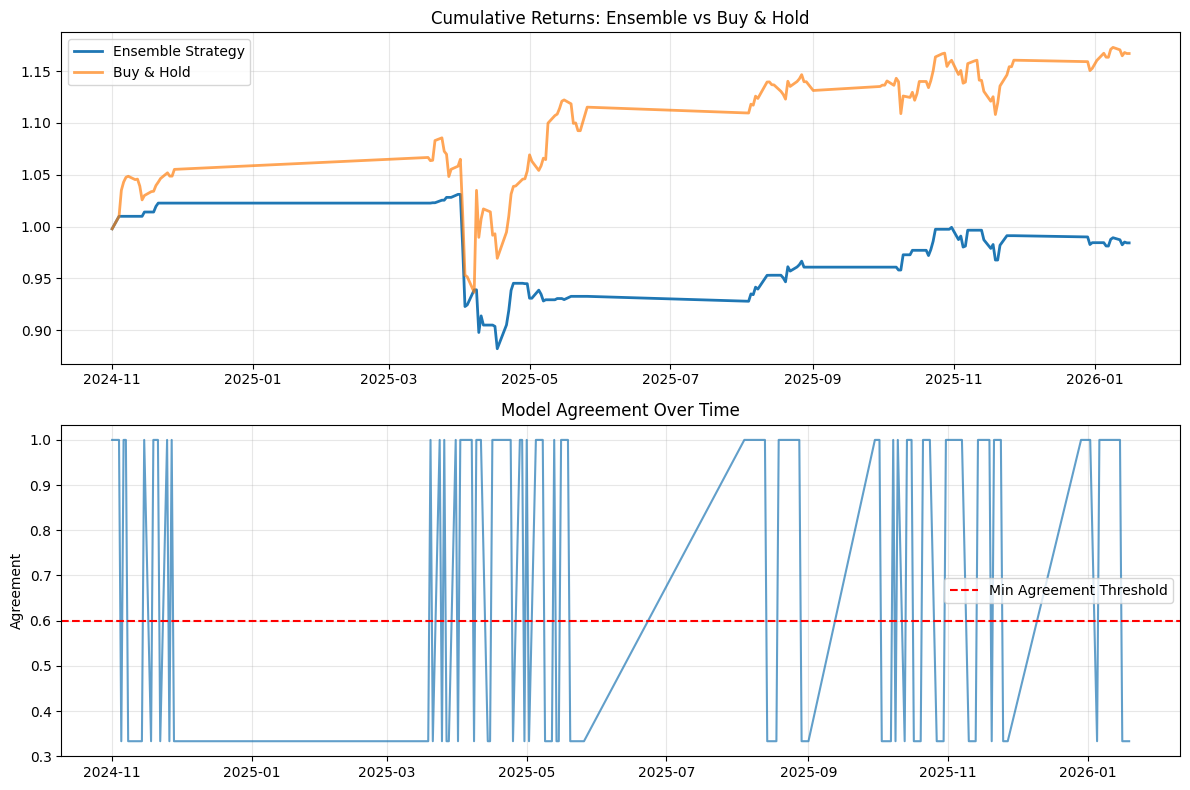

In [11]:
# Plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Cumulative returns
axes[0].plot(X_test.index, cum_strategy, label='Ensemble Strategy', linewidth=2)
axes[0].plot(X_test.index, cum_buyhold.values, label='Buy & Hold', alpha=0.7, linewidth=2)
axes[0].set_title('Cumulative Returns: Ensemble vs Buy & Hold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Model agreement over time
axes[1].plot(X_test.index, agreement, alpha=0.7)
axes[1].axhline(y=0.6, color='r', linestyle='--', label='Min Agreement Threshold')
axes[1].set_title('Model Agreement Over Time')
axes[1].set_ylabel('Agreement')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Practice Exercises

1. **More Diversity**: Add models from different families (SVM, neural nets).

2. **Dynamic Weighting**: Adjust model weights based on recent performance.

3. **Feature-Based Routing**: Use different models for different market regimes.

4. **Calibration**: Ensure probability outputs are well-calibrated.

In [12]:
# Exercise: Add SVM to ensemble (requires scaling)
from sklearn.pipeline import Pipeline

# Create pipeline with scaling for SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, kernel='rbf', C=1.0))
])

# Extended ensemble
extended_voting = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('svm', svm_pipeline),
    ],
    voting='soft'
)

extended_voting.fit(X_train, y_train)
ext_acc = extended_voting.score(X_test, y_test)
ext_proba = extended_voting.predict_proba(X_test)[:, 1]
ext_auc = roc_auc_score(y_test, ext_proba)

print("Extended Ensemble (with SVM)")
print("="*50)
print(f"Accuracy: {ext_acc:.4f}")
print(f"AUC: {ext_auc:.4f}")

Extended Ensemble (with SVM)
Accuracy: 0.5946
AUC: 0.5238


## Summary

Today we learned:
- Ensemble methods combine diverse models to reduce variance
- Model diversity is key - correlated models don't help
- Voting (hard/soft/weighted) averages predictions
- Stacking uses a meta-learner to combine base predictions
- For trading, filter signals by model agreement
- Ensembles often outperform single models, but add complexity